In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import gridspec
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers,models,datasets
from tensorflow.keras.optimizers import Adam


import time
import timeit
import warnings
warnings.filterwarnings("ignore") 


%matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set_theme(context = 'notebook', style='darkgrid',palette='dark')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB, CategoricalNB
import xgboost
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter




In [3]:
df = pd.read_csv('../creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
col_name = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class']

In [7]:
y = list(df.groupby(['Class'])['Class'].count())
y

[284315, 492]

In [8]:
total = y[0] + y[1]
w0 = total/(2 * y[0])
w1 = total/(2 * y[1])

class_weights = {0: w0, 1:w1}
class_weights

{0: 0.5008652375006595, 1: 289.4380081300813}

In [9]:
#We will use Robust Scaler as it is less prone to outliers
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

df['Amount_Scaled'] = robust.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_Scaled'] = robust.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
df.rename(columns = {'Amount_Scaled':'Amount', 'Time_Scaled':'Time'}, inplace = True)


df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount,Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [10]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount,Time
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,...,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,0.001727,0.927124,0.118914
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,3.495006,0.557903
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,-0.307413,-0.994983
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,-0.229162,-0.358210
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,0.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,0.770838,0.641790
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,358.683155,1.035022


In [11]:
df = df.drop(['V8','V13','V15','V17','V20','V22','V23','V24','V25','V26','V27','V28'], axis =1)


In [12]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V18,V19,V21,Class,Amount,Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.025791,0.403993,-0.018307,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.183361,-0.145783,-0.225775,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,-0.121359,-2.261857,0.247998,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,1.965775,-1.232622,-0.108300,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.038195,0.803487,-0.009431,0,0.670579,-0.994960


In [13]:
df.shape

(284807, 19)

In [14]:
df = df.sample(frac=1)

df_fraud= df.loc[df['Class'] == 1]
df_legitimate = df.loc[df['Class'] == 0].sample(n=492, replace = False)

df_balanced= pd.concat([df_fraud, df_legitimate]).sample(frac=1, random_state=10)
df_balanced.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V18,V19,V21,Class,Amount,Time
44556,-4.566342,3.353451,-4.572028,3.616119,-2.493138,-1.090000,-5.551433,-2.424414,-5.699922,3.586824,-6.636229,-7.245550,-6.856810,-4.591883,0.936940,2.674466,1,-0.293440,-0.501662
220725,-1.169203,1.863414,-2.515135,5.463681,-0.297971,1.364918,0.759219,-2.293921,-0.423784,2.375876,-3.244827,-5.152475,-1.022045,0.126460,1.819013,-0.393090,1,4.228184,0.676559
191753,1.988171,-0.545830,-1.748809,-0.738284,1.839428,3.706949,-1.096053,1.025073,-0.106277,0.054414,0.493342,0.238136,0.259629,-0.222016,-0.310416,-0.143457,0,-0.290924,0.525241
263080,2.132386,0.705608,-3.530759,0.514779,1.527175,-1.716268,1.132791,0.128904,-1.000805,-0.191191,-0.323794,-1.422064,-0.387162,0.610976,-0.221267,0.163739,1,-0.293440,0.894031
135718,-0.885254,1.790649,-0.945149,3.853433,-1.543510,0.188582,-2.988383,-2.294535,-1.886176,1.904284,-4.002414,-2.801915,-2.348740,-0.827308,1.732382,0.746160,1,-0.201635,-0.039004


In [15]:
df = df_balanced

In [16]:
X = df.drop('Class', axis=1)
y = df['Class']

print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))


Shape of X: (984, 18)
Shape of y: (984,)


# DO NOT RUN THIS AGAIN

# STARTS

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [141]:
pd.DataFrame(X_train).to_csv("X_train_SMOTE_u.csv", index=None)
pd.DataFrame(y_train, columns={"Class"}).to_csv("Y_train_SMOTE_u.csv", index=None)
pd.DataFrame(X_test).to_csv("X_test_u.csv", index=None)
pd.DataFrame(y_test).to_csv("y_test_u.csv", index=None)

# ENDS

# <font color=blue> Check shape after SMOTE

In [142]:
X_train = pd.read_csv('X_train_SMOTE_u.csv')
y_train = pd.read_csv('Y_train_SMOTE_u.csv').to_numpy()
X_test = pd.read_csv('X_test_u.csv')
y_test = pd.read_csv('y_test_u.csv')

In [143]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(787, 18)
(787, 1)
(197, 18)
(197, 1)


In [156]:
X_test_og = pd.read_csv('X_test.csv')
y_test_og = pd.read_csv('y_test.csv')

In [157]:
print(X_test_og.shape)
print(y_test_og.shape)

(56962, 18)
(56962, 1)


# <font color=blue>Confusion Matrix


In [20]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

def plot_confusion_matrix(cm, model):
    plt.figure(figsize=(8,6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['Not Fraud','Fraud'])
    ax.yaxis.set_ticklabels(['Not Fraud','Fraud'])
    plt.show()

# <font color=blue> Function for Metrics Eval

In [21]:
def calc_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    m = dict()
    m['recall'] = 100*tp/(tp+fn)
    m['precision'] = 100*tp/(tp+fp)
    m['accuracy'] = 100*(tn+tp)/(tn+tp+fn+fp)
    m['f1'] = 2/((1/m['precision'])+(1/m['recall']))
    m['mcc'] = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tn+fn)*(tn+fp)*(tp+fn))
    
    return m

# <font color=blue> Precision Recall Curve

In [22]:
from sklearn.metrics import precision_recall_curve

def plot_prcurve(precision, recall, model):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'Precision Recall Curve - {model}')    
    ax.plot(recall, precision, label="")

    baseline = y_test[y_test==1].count()/y_test.count()    
    ax.plot([0,1], [baseline, baseline], linestyle='--', label='Baseline')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='center left');


# <font color = red> Model - Logistic regression</font>

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [24]:
lr = LogisticRegression(C=1,penalty='l1', solver="liblinear", verbose=5)
lr.fit(X_train, y_train.ravel())

[LibLinear]

LogisticRegression(C=1, penalty='l1', solver='liblinear', verbose=5)

# Logistic Regression Confusion Matrix

Recall in the Training dataset: 91.12271540469973%
Precision in the Training dataset: 97.75910364145658%


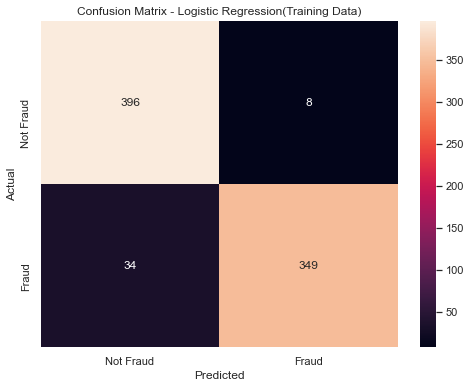

In [25]:
# Prediction on Training Dataset

y_train_pre = lr.predict(X_train)

cm_lr = confusion_matrix(y_train, y_train_pre)
tn, fp, fn, tp = cm_lr.ravel()

print(f"Recall in the Training dataset: {tp/(tp+fn)*100}%")
print(f"Precision in the Training dataset: {tp/(tp+fp)*100}%")


plot_confusion_matrix(cm_lr, "Logistic Regression(Training Data)")

## Prediction on Testing Data

Recall in the Testing dataset: 89.90825688073394%
Precision in the Testing dataset: 94.23076923076923%


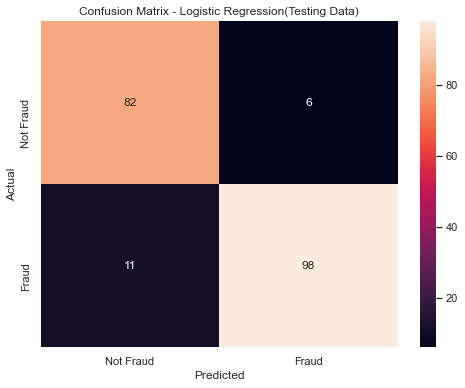

In [26]:
y_pre = lr.predict(X_test)

cm_lr_ = confusion_matrix(y_test, y_pre)
tn, fp, fn, tp = cm_lr_.ravel()

print(f"Recall in the Testing dataset: {tp/(tp+fn)*100}%")
print(f"Precision in the Testing dataset: {tp/(tp+fp)*100}%")


plot_confusion_matrix(cm_lr_, "Logistic Regression(Testing Data)")

In [27]:
metrics_lr = calc_metrics(cm_lr_)

In [28]:
for k,v in metrics_lr.items():
    print(k,v)

recall 89.90825688073394
precision 94.23076923076923
accuracy 91.37055837563452
f1 92.01877934272301
mcc 0.8274573012858999


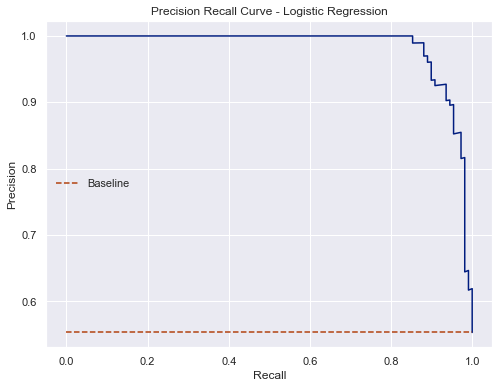

In [29]:
prob = lr.predict_proba(X_test)[:, 1]

prec, rec, thresh = precision_recall_curve(y_test,prob)

plot_prcurve(prec, rec, "Logistic Regression")

In [30]:
pr_auc = auc(rec, prec)
pr_auc
metrics_lr['pr_auc'] = pr_auc

In [31]:
metrics_lr

{'recall': 89.90825688073394,
 'precision': 94.23076923076923,
 'accuracy': 91.37055837563452,
 'f1': 92.01877934272301,
 'mcc': 0.8274573012858999,
 'pr_auc': 0.9834670431035232}

# <font color = red> Model - KNN</font>


In [32]:
knn = GridSearchCV(KNeighborsClassifier(), {'n_neighbors' : [2,3,4,5,20,25,30,40,50]}, scoring='recall', refit = True, verbose = 1)

In [33]:

startknn = timeit.default_timer()
knn.fit(X_train, y_train.ravel())

y_pred_knn = knn.predict(X_test)

endknn = timeit.default_timer()



Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [34]:
knn.best_params_

{'n_neighbors': 3}

In [35]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

metrics_knn = calc_metrics(cm_knn)

In [36]:
print("Training Time: ", endknn - startknn)
for k,v in metrics_knn.items():
    print(k,v)

Training Time:  5.558040499999947
recall 93.57798165137615
precision 94.44444444444444
accuracy 93.4010152284264
f1 94.00921658986175
mcc 0.8666949086749612


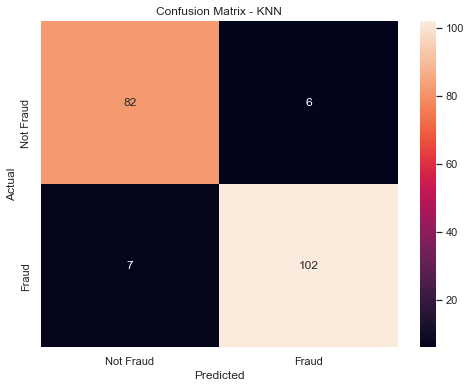

In [37]:
name = "KNN"
plot_confusion_matrix(cm_knn, name)


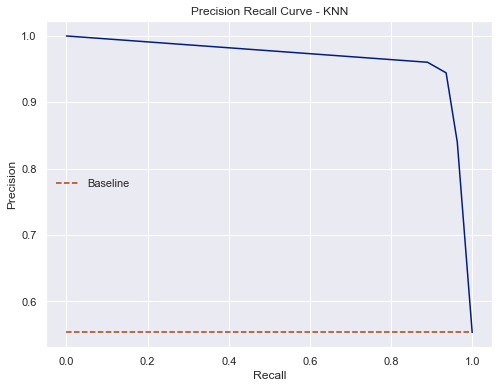

In [38]:
prec_knn, rec_knn, th_knn = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1])
plot_prcurve(prec_knn, rec_knn, "KNN")

In [39]:
pr_auc_knn = auc(rec_knn, prec_knn)
pr_auc_knn

0.966097016351847

# <font color=red> Model Random Forest</font>

In [40]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 123)


In [41]:
startrfc = timeit.default_timer()
rfc.fit(X_train, y_train.ravel())
endrfc = timeit.default_timer()

In [42]:
y_pred_rfc = rfc.predict(X_test)

In [43]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

metrics_rfc = calc_metrics(cm_rfc)

In [44]:
print("Training Time: ", endrfc - startrfc)
for k,v in metrics_rfc.items():
    print(k,v)

Training Time:  0.2906600999999682
recall 91.74311926605505
precision 95.23809523809524
accuracy 92.89340101522842
f1 93.45794392523365
mcc 0.8575785886220075


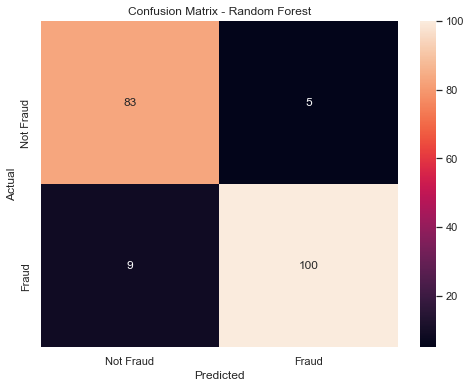

In [45]:
name = "Random Forest"
plot_confusion_matrix(cm_rfc, name)


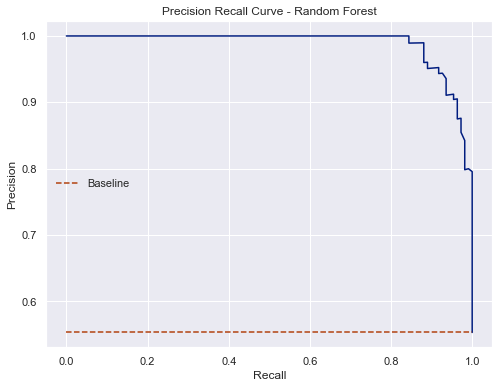

In [46]:
prec_rfc, rec_rfc, th_rfc = precision_recall_curve(y_test, rfc.predict_proba(X_test)[:,1])
plot_prcurve(prec_rfc, rec_rfc, "Random Forest")

In [47]:
pr_auc_rfc = auc(rec_rfc, prec_rfc)
pr_auc_rfc

0.9881254698175412

# <font color=red> Model - Decision Tree </font>

In [48]:
dt = DecisionTreeClassifier(random_state = 123, class_weight = class_weights)

In [49]:
startdt = timeit.default_timer()
dt.fit(X_train, y_train.ravel())
enddt = timeit.default_timer()

In [50]:
y_pred_dt = dt.predict(X_test)

In [51]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

metrics_dt = calc_metrics(cm_dt)

In [52]:
print("Training Time: ", enddt - startdt)
for k,v in metrics_dt.items():
    print(k,v)

Training Time:  0.02499310000001742
recall 88.07339449541284
precision 92.3076923076923
accuracy 89.34010152284264
f1 90.14084507042254
mcc 0.7865516329412771


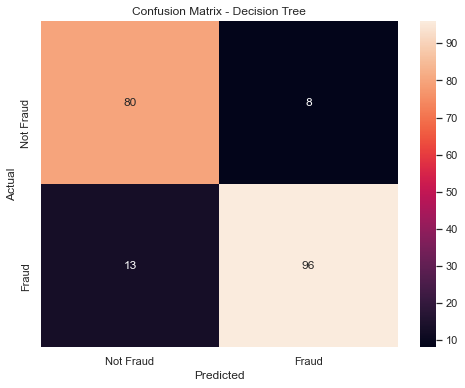

In [53]:
name = "Decision Tree"
plot_confusion_matrix(cm_dt, name)


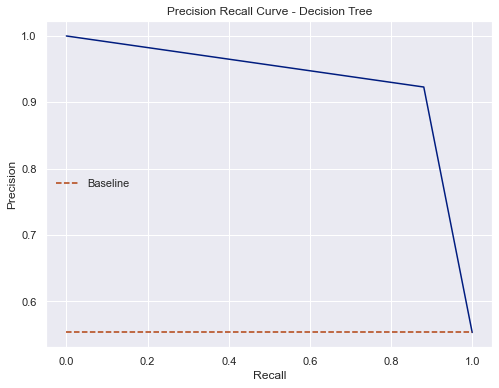

In [54]:
prec_dt, rec_dt, th = precision_recall_curve(y_test, dt.predict_proba(X_test)[:,1])
plot_prcurve(prec_dt, rec_dt, "Decision Tree")

In [55]:
pr_auc_dt = auc(rec_dt, prec_dt)
pr_auc_dt

0.9349003578733938

# <font color=red> Model - GaussianNB

In [56]:
nb = GaussianNB()

In [57]:
startnb = timeit.default_timer()
nb.fit(X_train, y_train.ravel())
endnb = timeit.default_timer()

In [58]:
y_pred_nb = nb.predict(X_test)

In [59]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

metrics_nb = calc_metrics(cm_nb)

In [60]:
print("Training Time: ", endnb - startnb)
for k,v in metrics_nb.items():
    print(k,v)

Training Time:  0.005943800000011379
recall 87.1559633027523
precision 98.95833333333333
accuracy 92.38578680203045
f1 92.6829268292683
mcc 0.8555702969669753


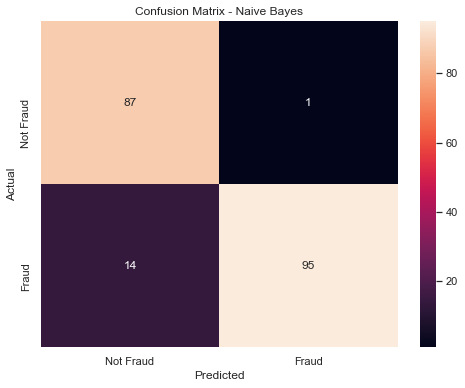

In [61]:
name = "Naive Bayes"
plot_confusion_matrix(cm_nb, name)


In [62]:
prec_nb, rec_nb, _ = precision_recall_curve(y_test, nb.predict_proba(X_test)[:,1])

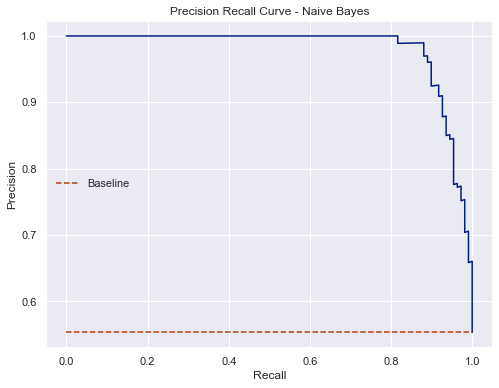

In [63]:
plot_prcurve(prec_nb, rec_nb, name)

In [64]:
pr_auc_nb = auc(rec_nb, prec_nb)
pr_auc_nb

0.9803373439937363

# <font color=red> Model - Complement NB

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
mms = MinMaxScaler()

In [67]:
X_train_mms = mms.fit_transform(X_train)
X_test_mms = mms.transform(X_test)

In [68]:
cnb = ComplementNB()

In [69]:
startcnb = timeit.default_timer()
cnb.fit(X_train_mms, y_train.ravel())
endcnb = timeit.default_timer()

In [70]:
y_pred_cnb = cnb.predict(X_test_mms)

In [71]:
cm_cnb = confusion_matrix(y_test, y_pred_cnb)

metrics_cnb = calc_metrics(cm_cnb)

In [72]:
print("Training Time: ", endcnb - startcnb)
for k,v in metrics_cnb.items():
    print(k,v)

Training Time:  0.0027072999999973035
recall 78.89908256880734
precision 100.0
accuracy 88.3248730964467
f1 88.2051282051282
mcc 0.7908895246399077


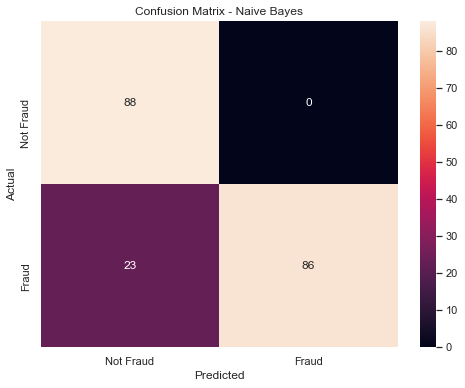

In [73]:
name = "Naive Bayes"
plot_confusion_matrix(cm_cnb, name)


In [74]:
prec_cnb, rec_cnb, _ = precision_recall_curve(y_test, cnb.predict_proba(X_test_mms)[:,1])

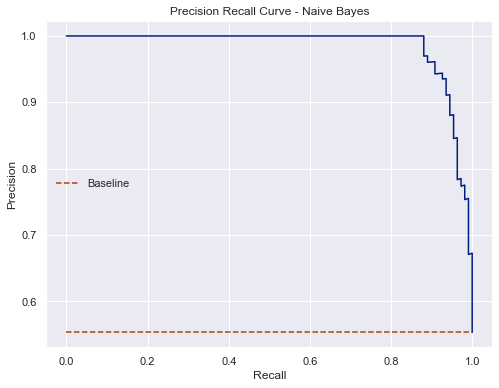

In [75]:
plot_prcurve(prec_cnb, rec_cnb, name)

In [76]:
pr_auc_cnb = auc(rec_cnb, prec_cnb)
pr_auc_cnb

0.9847424346381078


# <font color = red> Model - Ada Boost with base learners as Logistic Regression

In [77]:
ada = AdaBoostClassifier(base_estimator = lr, n_estimators=100, random_state = 123)

In [78]:
startada = timeit.default_timer()
ada.fit(X_train, y_train.ravel())
endada = timeit.default_timer()

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

In [79]:
y_pred_ada = ada.predict(X_test)

In [80]:
cm_ada = confusion_matrix(y_test, y_pred_ada)

metrics_ada = calc_metrics(cm_ada)

In [81]:
print("Training Time: ", endada - startada)
for k,v in metrics_ada.items():
    print(k,v)

Training Time:  3.754104199999972
recall 95.41284403669725
precision 72.72727272727273
accuracy 77.66497461928934
f1 82.53968253968254
mcc 0.5694626159659945


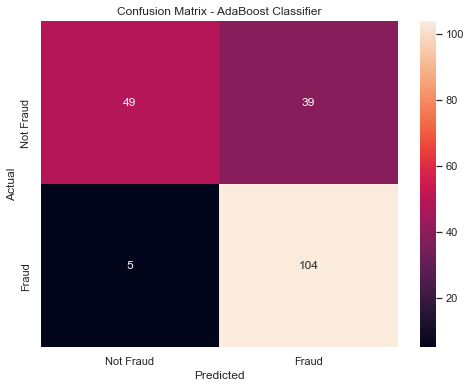

In [82]:
name = "AdaBoost Classifier"
plot_confusion_matrix(cm_ada, name)


In [83]:
prec_ada, rec_ada, _ = precision_recall_curve(y_test, ada.predict_proba(X_test)[:,1])

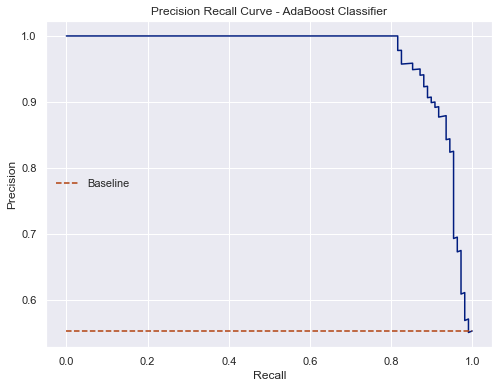

In [84]:
plot_prcurve(prec_ada, rec_ada, name)

In [85]:
pr_auc_ada = auc(rec_ada, prec_ada)
pr_auc_ada

0.9710159207507426

# <font color=red> Model - Gradient Boosting

In [86]:
gb = GradientBoostingClassifier(n_estimators = 100, random_state = 123)

In [87]:
startgb = timeit.default_timer()
gb.fit(X_train, y_train.ravel())
endgb = timeit.default_timer()

In [88]:
y_pred_gb = gb.predict(X_test)

In [89]:
cm_gb = confusion_matrix(y_test, y_pred_gb)

metrics_gb = calc_metrics(cm_gb)

In [90]:
print("Training Time: ", endgb - startgb)
for k,v in metrics_gb.items():
    print(k,v)

Training Time:  0.37919180000000097
recall 92.66055045871559
precision 94.39252336448598
accuracy 92.89340101522842
f1 93.5185185185185
mcc 0.8567283414688497


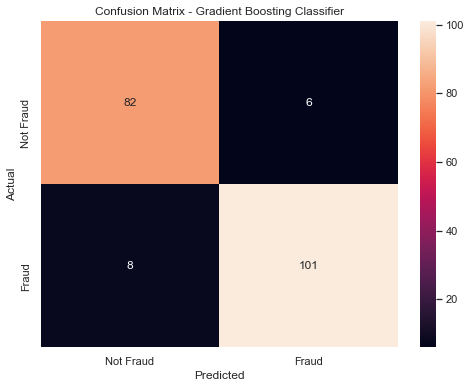

In [91]:
name = "Gradient Boosting Classifier"
plot_confusion_matrix(cm_gb, name)


In [92]:
prec_gb, rec_gb, _ = precision_recall_curve(y_test, gb.predict_proba(X_test)[:,1])

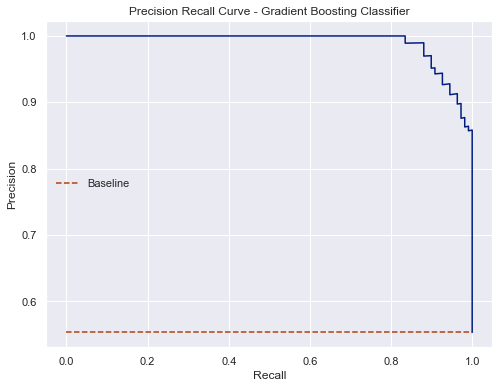

In [93]:
plot_prcurve(prec_gb, rec_gb, name)

In [94]:
pr_auc_gb = auc(rec_gb, prec_gb)
pr_auc_gb

0.9899102139872492

# <font color=red> Model - XG Boost

In [95]:
xgb = xgboost.XGBClassifier(objective="binary:logistic", random_state=42, verbose=2)

In [96]:
startxgb = timeit.default_timer()
xgb.fit(X_train, y_train.ravel())
endxgb = timeit.default_timer()

[18:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [97]:
y_pred_xgb = xgb.predict(X_test)

In [98]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

metrics_xgb = calc_metrics(cm_xgb)

In [99]:
cm_xgb

array([[ 81,   7],
       [  8, 101]], dtype=int64)

In [100]:
print("Training Time: ", endxgb - startxgb)
for k,v in metrics_xgb.items():
    print(k,v)

Training Time:  1.434008399999982
recall 92.66055045871559
precision 93.51851851851852
accuracy 92.38578680203045
f1 93.08755760368665
mcc 0.8461783384984451


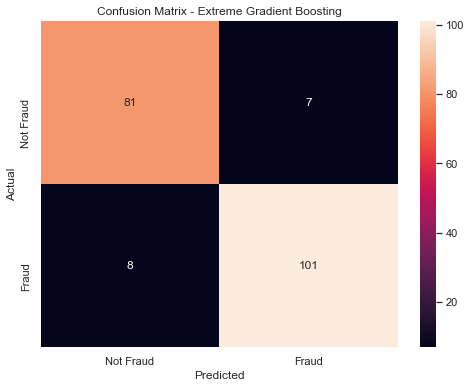

In [101]:
name = "Extreme Gradient Boosting"
plot_confusion_matrix(cm_xgb, name)


In [102]:
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:,1])

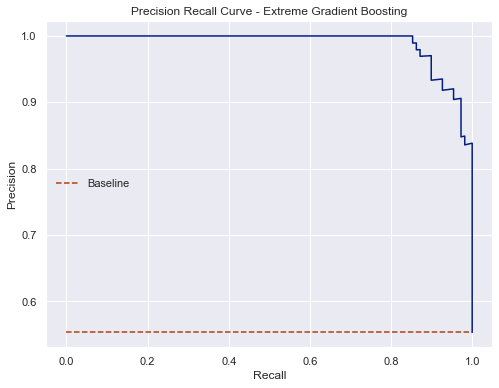

In [103]:
plot_prcurve(prec_xgb, rec_xgb, name)

In [104]:
pr_auc_xgb = auc(rec_xgb, prec_xgb)
pr_auc_xgb

0.9887358855523358

# <font color=red> LGBM

In [145]:
lgbm = LGBMClassifier()

In [146]:
startlgbm = timeit.default_timer()
lgbm.fit(X_train, y_train.ravel())
endlgbm = timeit.default_timer()

In [147]:
y_pred_lgbm = lgbm.predict(X_test)

In [149]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

metrics_lgbm = calc_metrics(cm_lgbm)

In [150]:
print("Training Time: ", endlgbm - startlgbm)
for k,v in metrics_lgbm.items():
    print(k,v)

Training Time:  0.21188940000138246
recall 89.90825688073394
precision 94.23076923076923
accuracy 91.37055837563452
f1 92.01877934272301
mcc 0.8274573012858999


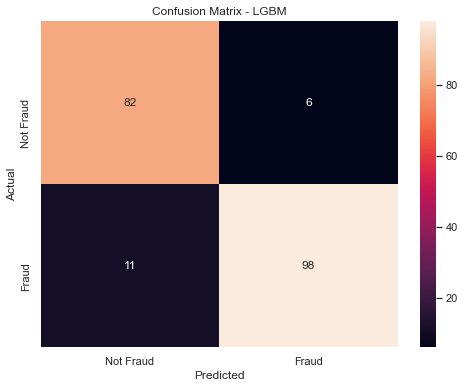

In [151]:
name = "LGBM"
plot_confusion_matrix(cm_lgbm, name)


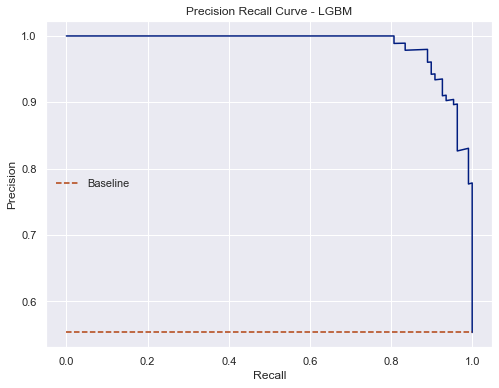

In [152]:
prec_lgbm, rec_lgbm, _ = precision_recall_curve(y_test, lgbm.predict_proba(X_test)[:,1])
plot_prcurve(prec_lgbm, rec_lgbm, name)

In [153]:
pr_auc_lgbm = auc(rec_lgbm, prec_lgbm)
pr_auc_lgbm

0.9861704004922117

# <font color=red> Model - SGD (One class SVM)

In [105]:
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM
import timeit
import numpy

In [106]:
svc = SGDOneClassSVM(max_iter = 100)

In [107]:
startsvc= timeit.default_timer()
svc.fit(X_train)
endsvc = timeit.default_timer()

In [108]:
y_pred_svc = svc.predict(X_test)

In [109]:
type(y_pred_svc)

numpy.ndarray

In [110]:
cm_svc = confusion_matrix(y_test, y_pred_svc)

act_cm_svc = [x for i in cm_svc for x in i if x!=0]
cmsvc = numpy.array(act_cm_svc)
metrics_svc = calc_metrics(cmsvc)

In [111]:
print("Training Time: ", endsvc - startsvc)
for k,v in metrics_svc.items():
    print(k,v)

Training Time:  0.007444899999995869
recall 91.74311926605505
precision 89.28571428571429
accuracy 89.34010152284264
f1 90.49773755656108
mcc 0.7840156095556652


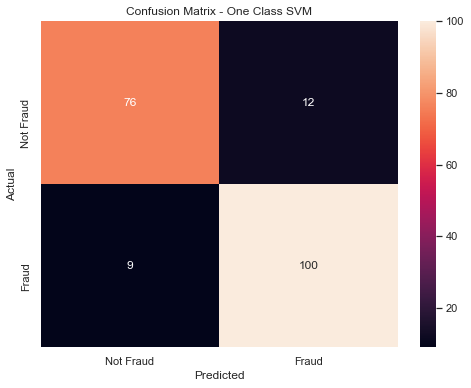

In [112]:
name = "One Class SVM"
plot_confusion_matrix(cmsvc.reshape(2,2), name)


# <font color=red> Model - MLP Classifier

In [113]:
from sklearn.neural_network import MLPClassifier

In [114]:
mlp = MLPClassifier(random_state=1, batch_size = 2048, max_iter=100, verbose = True)

In [115]:
startmlp= timeit.default_timer()
mlp.fit(X_train, y_train.ravel())
endmlp = timeit.default_timer()

Iteration 1, loss = 0.81203497
Iteration 2, loss = 0.72356327
Iteration 3, loss = 0.66150853
Iteration 4, loss = 0.61902154
Iteration 5, loss = 0.58880396
Iteration 6, loss = 0.56583269
Iteration 7, loss = 0.54712544
Iteration 8, loss = 0.53101945
Iteration 9, loss = 0.51659648
Iteration 10, loss = 0.50336547
Iteration 11, loss = 0.49104508
Iteration 12, loss = 0.47946231
Iteration 13, loss = 0.46851945
Iteration 14, loss = 0.45814560
Iteration 15, loss = 0.44828427
Iteration 16, loss = 0.43888969
Iteration 17, loss = 0.42992411
Iteration 18, loss = 0.42134743
Iteration 19, loss = 0.41311416
Iteration 20, loss = 0.40519924
Iteration 21, loss = 0.39756902
Iteration 22, loss = 0.39020066
Iteration 23, loss = 0.38306771
Iteration 24, loss = 0.37615910
Iteration 25, loss = 0.36945500
Iteration 26, loss = 0.36293671
Iteration 27, loss = 0.35659505
Iteration 28, loss = 0.35042428
Iteration 29, loss = 0.34441332
Iteration 30, loss = 0.33856280
Iteration 31, loss = 0.33286509
Iteration 32, los

In [116]:
y_pred_mlp = mlp.predict(X_test)

In [117]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

metrics_mlp = calc_metrics(cm_mlp)

In [118]:
print("Training Time: ", endmlp - startmlp)
for k,v in metrics_mlp.items():
    print(k,v)

Training Time:  0.5444573999999989
recall 91.74311926605505
precision 93.45794392523365
accuracy 91.87817258883248
f1 92.59259259259258
mcc 0.8362309546253516


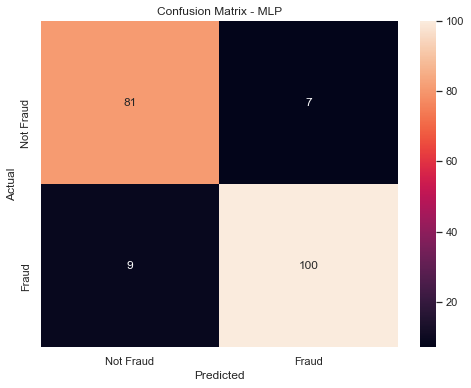

In [119]:
name = "MLP"
plot_confusion_matrix(cm_mlp, name)


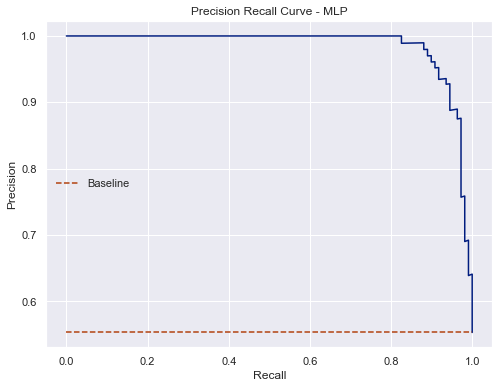

In [120]:
prec_mlp, rec_mlp, _ = precision_recall_curve(y_test, mlp.predict_proba(X_test)[:,1])
plot_prcurve(prec_mlp, rec_mlp, name)

In [121]:
pr_auc_mlp = auc(rec_mlp, prec_mlp)
pr_auc_mlp

0.9847688332307603

# <font color = red> Model - ANN


In [122]:
ann = tf.keras.models.Sequential()

In [123]:
X_train.shape

(787, 18)

In [124]:
y = list(df.groupby(['Class'])['Class'].count())
total = y[0] + y[1]
total

984

In [125]:
metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.Accuracy(name="Accuracy"),
]

w0 = total/(2 * y[0])
w1 = total/(2 * y[1])
class_weight = {0: w0, 1:w1}


In [126]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "recall", patience=10, mode="max")

In [127]:
ann.add(tf.keras.layers.Dense(512, input_shape=(X_train.shape[1], ), activation='relu'))
ann.add(tf.keras.layers.Dense(512, activation="relu"))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(512, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [128]:
ann.compile(Adam(lr=0.01), loss = "binary_crossentropy", metrics=metrics)

In [129]:
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               9728      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 535,553
Trainable params: 535,553
Non-trainable params: 0
__________________________________________________

In [130]:
startann = timeit.default_timer()
ann.fit(X_train, y_train, epochs=30, batch_size=2048, class_weight = class_weight)
endan = timeit.default_timer()

Epoch 1/30
1/1 [==============================] - 0s 2ms/step - loss: 0.9897 - fn: 318.0000 - fp: 60.0000 - tn: 344.0000 - tp: 65.0000 - precision: 0.5200 - recall: 0.1697 - Accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 2ms/step - loss: 3.1831 - fn: 0.0000e+00 - fp: 404.0000 - tn: 0.0000e+00 - tp: 383.0000 - precision: 0.4867 - recall: 1.0000 - Accuracy: 0.4282
Epoch 3/30
1/1 [==============================] - 0s 2ms/step - loss: 1.2197 - fn: 159.0000 - fp: 0.0000e+00 - tn: 404.0000 - tp: 224.0000 - precision: 1.0000 - recall: 0.5849 - Accuracy: 0.0407
Epoch 4/30
1/1 [==============================] - 0s 3ms/step - loss: 0.2852 - fn: 40.0000 - fp: 24.0000 - tn: 380.0000 - tp: 343.0000 - precision: 0.9346 - recall: 0.8956 - Accuracy: 0.3634
Epoch 5/30
1/1 [==============================] - 0s 2ms/step - loss: 0.2754 - fn: 20.0000 - fp: 48.0000 - tn: 356.0000 - tp: 363.0000 - precision: 0.8832 - recall: 0.9478 - Accuracy: 0.3964
Epoch 6/30
1/1 [===============

In [131]:
y_pred_ann = ann.predict(X_test)

y_pred_ann

array([[1.00000000e+00],
       [1.00000000e+00],
       [1.91405118e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.56256557e-03],
       [1.05446577e-03],
       [1.10697385e-06],
       [5.75563014e-02],
       [1.00000000e+00],
       [3.02967429e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.17422843e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.47004628e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.81557548e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [3.55887933e-05],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.55342305e-01],
       [6.41208317e-05],
       [6.24626875e-04],
       [1.24888038e-05],
       [1.86544478e-01],
       [1.00000000e+00],
       [3.84747982e-04],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.94758785e-02],


In [132]:
yfinal_pred = y_pred_ann.ravel().astype('int64')
# yfinal_pred = np.delete(y_pred_ann, 1, 1).ravel().astype('int64')

In [133]:
yfinal_pred

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
      dtype=int64)

In [134]:
cm_ann = confusion_matrix(y_test, yfinal_pred)

metrics_ann = calc_metrics(cm_ann)

print("Training Time: ", endan - startann)
for k,v in metrics_ann.items():
    print(k,v)

Training Time:  3.0616273999999635
recall 89.90825688073394
precision 98.98989898989899
accuracy 93.90862944162437
f1 94.23076923076924
mcc 0.8826721665214399


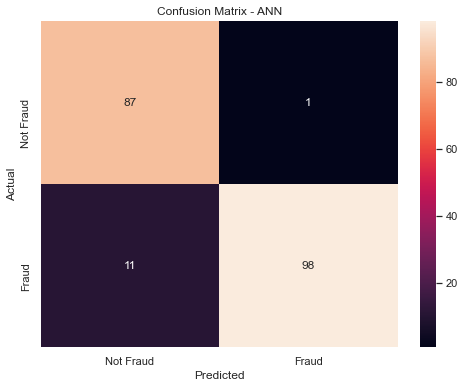

In [135]:
name = "ANN"
plot_confusion_matrix(cm_ann, name)


In [158]:
metrics_ann['time'] = endann - startann


NameError: name 'endann' is not defined

# Final Scores

In [139]:
pd.DataFrame([metrics_lr, metrics_knn, metrics_dt, metrics_rfc, metrics_nb, metrics_ada, metrics_gb, metrics_xgb, 
              metrics_svc, metrics_ann] ,index = ['LR','KNN','DT','RF','NB','AdaBoost','Gradient Boost','XG Boost',
                                                  'One Class SVM', 'ANN'])

,recall,precision,accuracy,f1,mcc,pr_auc
LR,89.908257,94.230769,91.370558,92.018779,0.827457,0.983467
KNN,93.577982,94.444444,93.401015,94.009217,0.866695,NaN
DT,88.073394,92.307692,89.340102,90.140845,0.786552,NaN
RF,91.743119,95.238095,92.893401,93.457944,0.857579,NaN
NB,87.155963,98.958333,92.385787,92.682927,0.855570,NaN
AdaBoost,95.412844,72.727273,77.664975,82.539683,0.569463,NaN
Gradient Boost,92.660550,94.392523,92.893401,93.518519,0.856728,NaN
XG Boost,92.660550,93.518519,92.385787,93.087558,0.846178,NaN
One Class SVM,91.743119,89.285714,89.340102,90.497738,0.784016,NaN
ANN,89.908257,98.989899,93.908629,94.230769,0.882672,NaN
